In [2]:
# Dataframes
import pandas as pd

# SK-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#NLTK
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# String manipulation
import re
import string

# Random
import random

# Keras
from keras_preprocessing.text import Tokenizer
from keras import Sequential, initializers, regularizers, layers, utils, Input

# Plotting
import matplotlib.pyplot as plt

# Numpy
import numpy as np

# Itertools
import itertools


In [3]:
# Function to remove html links & mentions
def remove_html_mentions(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

# Function to remove numbers
def remove_numbers(text):
    text = ''.join([''.join([i for i in word if not i.isdigit()]) for word in text])
    return text

# Function to remove punctuation
def remove_punctuation(text):
    text = ''.join([symbol for symbol in text if symbol not in string.punctuation])
    return text

tokenizer = RegexpTokenizer('\s+', gaps=True)
# Function to tokenize text
def tokenize_text(text):
    tokenized_text = tokenizer.tokenize(text)
    return tokenized_text

# Function to remove stopwords
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

lemmatizer = WordNetLemmatizer()
# Function to lemmatize words:
def lemmatize_words(text):
    lem_text = [lemmatizer.lemmatize(word) for word in text]
    return lem_text

stemmer = PorterStemmer()
# Function to stem words
def stem_words(text):
    stem_text = ' '.join([stemmer.stem(word) for word in text])
    return stem_text

In [5]:
def clean(data):
    data = data.apply(lambda x: remove_html_mentions(x))
    data = data.apply(lambda x: remove_numbers(x))
    data = data.apply(lambda x: remove_punctuation(x))
    data = data.apply(lambda x: tokenize_text(x.lower()))
    data = data.apply(lambda x: remove_stopwords(x))
    data = data.apply(lambda x: lemmatize_words(x))
    data = data.apply(lambda x: stem_words(x))
    return data

In [6]:
def train_test_validate(x, y, t_size=.25, validation_size=.25):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=t_size, random_state=1)

    val_size = round((1-t_size)*validation_size,2)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=1)

    train = pd.concat([x_train, y_train], axis=1)
    test = pd.concat([x_test, y_test], axis=1)
    validate = pd.concat([x_val, y_val], axis=1)

    return train, test, validate

In [7]:
f = '../input/sentiment140/training.1600000.processed.noemoticon.csv'

# Total number of data points
num_lines = sum(1 for _ in open(f, encoding='ISO-8859-1'))

# Number of data points to use
size = int(num_lines / 50)
skip_idx = random.sample(range(1, num_lines), num_lines - size)
tweet_data = pd.read_csv(f, skiprows=skip_idx, encoding='ISO-8859-1')

In [8]:
tweet_data.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [9]:
tweet_data.loc[tweet_data['target'] == 0, 'target'] = 0
tweet_data.loc[tweet_data['target'] == 4, 'target'] = 1

In [10]:
target, text = tweet_data.iloc[:,0], tweet_data.iloc[:,5]

In [11]:
text = clean(text)

In [12]:
train, test, validate = train_test_validate(text, target)

In [13]:
# Create tokenizer
num_words_keep = 1000
tokenizer = Tokenizer(num_words=num_words_keep,filters='',lower=False,split=' ',
                      char_level=False, oov_token=None)

In [14]:
# Fit tokenizer on training data
x_train = train.iloc[:,0]

tokenizer.fit_on_texts(texts=x_train)
modes = ['binary', 'count', 'tfidf', 'freq']

Use the counts of each word in the tweet when fitting the tokenizer.

In [15]:
# Training data
y_train = train.iloc[:,1]

x_train = tokenizer.texts_to_matrix(x_train, mode=modes[1])
y_train = utils.to_categorical(y_train, num_classes=2)

In [16]:
# Validation data
x_validate = validate.iloc[:,0]
x_validate = tokenizer.texts_to_matrix(x_validate, mode=modes[1])

y_validate = validate.iloc[:,1]
y_validate = utils.to_categorical(y_validate, num_classes=2)

In [17]:
# Test data
x_test = test.iloc[:,0]
x_test = tokenizer.texts_to_matrix(x_test, mode=modes[1])

y_test = test.iloc[:,1]

In [18]:
# Class Names for labels 0:Negative, 1:Positive
class_names = ['Negative', 'Positive']

In [22]:
# Implement model
model = Sequential()

activation_functions = ['relu','sigmoid','tanh']

initialiser = initializers.GlorotNormal(seed=1) # Mitigating risk of vanishing/exploding gradients


reg_constant1 = 0.01
l2_regulariser = regularizers.l2(l=reg_constant1)


dropout = layers.Dropout(.2, input_shape=(num_words_keep,))

layer1 = layers.Dense(
    units = num_words_keep/2,
    activation= activation_functions[0],
    use_bias=True,
    kernel_initializer=initialiser,
    bias_initializer='zeros',
    kernel_regularizer=l2_regulariser
)

layer2 = layers.Dense(
    units = 2,
    activation= activation_functions[1],
    use_bias=True,
    kernel_initializer=initialiser,
    bias_initializer='zeros'
)

model.add(Input(shape=(num_words_keep,)))
model.add(dropout)
model.add(layer1)
model.add(dropout)
model.add(layer2)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
# Train model
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=16,
                    epochs=25,
                    verbose=2, #one line per epoch
                    validation_data=(x_validate,y_validate),
                    shuffle=True,
                    validation_freq=1)

Epoch 1/25
1215/1215 - 6s - loss: 0.8387 - accuracy: 0.6468 - val_loss: 0.7058 - val_accuracy: 0.6726
Epoch 2/25
1215/1215 - 6s - loss: 0.7090 - accuracy: 0.6665 - val_loss: 0.6874 - val_accuracy: 0.6849
Epoch 3/25
1215/1215 - 6s - loss: 0.6957 - accuracy: 0.6705 - val_loss: 0.6692 - val_accuracy: 0.7013
Epoch 4/25
1215/1215 - 6s - loss: 0.6866 - accuracy: 0.6716 - val_loss: 0.6711 - val_accuracy: 0.6820
Epoch 5/25
1215/1215 - 6s - loss: 0.6772 - accuracy: 0.6736 - val_loss: 0.6566 - val_accuracy: 0.7009
Epoch 6/25
1215/1215 - 6s - loss: 0.6684 - accuracy: 0.6823 - val_loss: 0.6496 - val_accuracy: 0.7136
Epoch 7/25
1215/1215 - 6s - loss: 0.6668 - accuracy: 0.6849 - val_loss: 0.6410 - val_accuracy: 0.7182
Epoch 8/25
1215/1215 - 6s - loss: 0.6590 - accuracy: 0.6866 - val_loss: 0.6378 - val_accuracy: 0.7136
Epoch 9/25
1215/1215 - 6s - loss: 0.6567 - accuracy: 0.6878 - val_loss: 0.6365 - val_accuracy: 0.7092
Epoch 10/25
1215/1215 - 6s - loss: 0.6553 - accuracy: 0.6811 - val_loss: 0.6253 - 

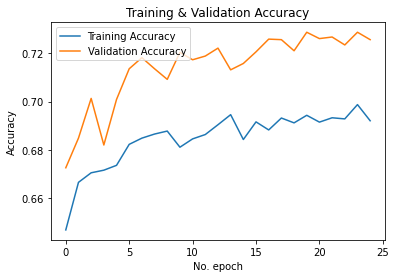

In [24]:
# Plot accuracy
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

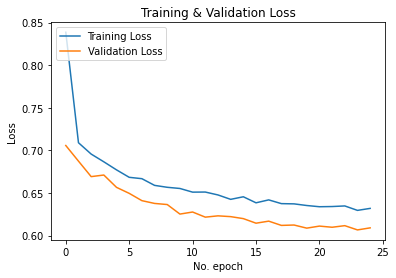

In [25]:
# Plot loss
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()
plt.close()

In [26]:
# Make new predictions:
y_pred = np.argmax(model.predict(x_test), axis=-1)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      4070
           1       0.67      0.80      0.73      3930

    accuracy                           0.71      8000
   macro avg       0.72      0.71      0.71      8000
weighted avg       0.72      0.71      0.71      8000



In [28]:
print(accuracy_score(y_test, y_pred))

0.710625
